In [29]:
import pandas as pd

data = pd.read_csv("out/small.dump.csv", sep=";")
data.head()

,timestep_time,edge_id,lane_id,vehicle_id,vehicle_pos,vehicle_speed
0,0.0,102,102_0,102_1060.qPKW.0,12.62,24.27
1,0.0,11,11_0,11_377.qPKW.0,21.28,29.06
2,0.0,11,11_0,11_879.qPKW.0,57.94,29.06
3,0.0,1148,1148_0,1148_857.qPKW.0,12.79,29.06
4,0.0,188,188_0,188_920.qPKW.0,18.87,29.06


In [30]:
data = data.drop(data[data["edge_id"].isna()].index.values)

In [31]:
data = data.drop(data[data.edge_id.str.startswith(':')].index.values)
data["vehicle_speed"] = data["vehicle_speed"].fillna(0)
data["vehicle_id"] = data["vehicle_id"].fillna(0).apply(lambda x: 1 if x != 0 else 0)

In [32]:
data.head()

,timestep_time,edge_id,lane_id,vehicle_id,vehicle_pos,vehicle_speed
0,0.0,102,102_0,1,12.62,24.27
1,0.0,11,11_0,1,21.28,29.06
2,0.0,11,11_0,1,57.94,29.06
3,0.0,1148,1148_0,1,12.79,29.06
4,0.0,188,188_0,1,18.87,29.06


In [33]:
overall = data.groupby(["edge_id"]).agg({'vehicle_id':'sum', 'vehicle_speed':'mean'}).reset_index()
overall = overall.rename(columns={"vehicle_id": "flow"})
overall["edge_id"] = pd.to_numeric(overall["edge_id"])
overall.head()

,edge_id,flow,vehicle_speed
0,1,12453,22.324466
1,10,1073,28.414026
2,100,3271,28.331626
3,1000,715,28.420797
4,1001,1590,28.397321


In [34]:
overall[overall["edge_id"] == 1046]

,edge_id,flow,vehicle_speed
37,1046,44938,6.016375


In [35]:
covered_edges = overall["edge_id"].unique()

for i in range(1220):
    if i not in covered_edges:
        overall.loc[len(overall.index)] = [i, 0, 0.0]
        
overall["edge_id"].nunique()

1220

In [37]:
edgelist = pd.read_csv("out/small.edges.csv", sep=";")
edgelist.head()

,edge_from,edge_id,edge_length,edge_numLanes,edge_speed,edge_to
0,1614922744,0,23.141939,1,29.0576,1614922747
1,269459339,1,60.826398,1,29.0576,269459341
2,1621320618,2,109.464966,1,29.0576,1621320622
3,269459229,3,160.720645,1,29.0576,269459230
4,607954833,4,173.017706,1,29.0576,1613371666


In [38]:
edgelist = pd.merge(edgelist, overall, on="edge_id")

ordered_cols = ["edge_id", "edge_from", "edge_to", "edge_length", "edge_numLanes", "edge_speed", "flow", "vehicle_speed"]
edgelist = edgelist[ordered_cols]

edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,1614922744,1614922747,23.141939,1,29.0576,0.0,0.000000
1,1,269459339,269459341,60.826398,1,29.0576,12453.0,22.324466
2,2,1621320618,1621320622,109.464966,1,29.0576,752.0,28.399561
3,3,269459229,269459230,160.720645,1,29.0576,12627.0,28.409249
4,4,607954833,1613371666,173.017706,1,29.0576,430964.0,1.462613


In [39]:
edgelist["flow"].nunique()

666

In [40]:
(edgelist["flow"] == 0).sum()

510

In [41]:
edgelist.to_csv("out/small.results.csv", index=False)

In [43]:
nodes = pd.read_csv("out/small.nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
269459457,51630.40,48021.0
317640716,41265.12,8394.4
317640717,41278.88,8053.0
317640718,41306.24,7498.2
317640719,41361.28,6929.2


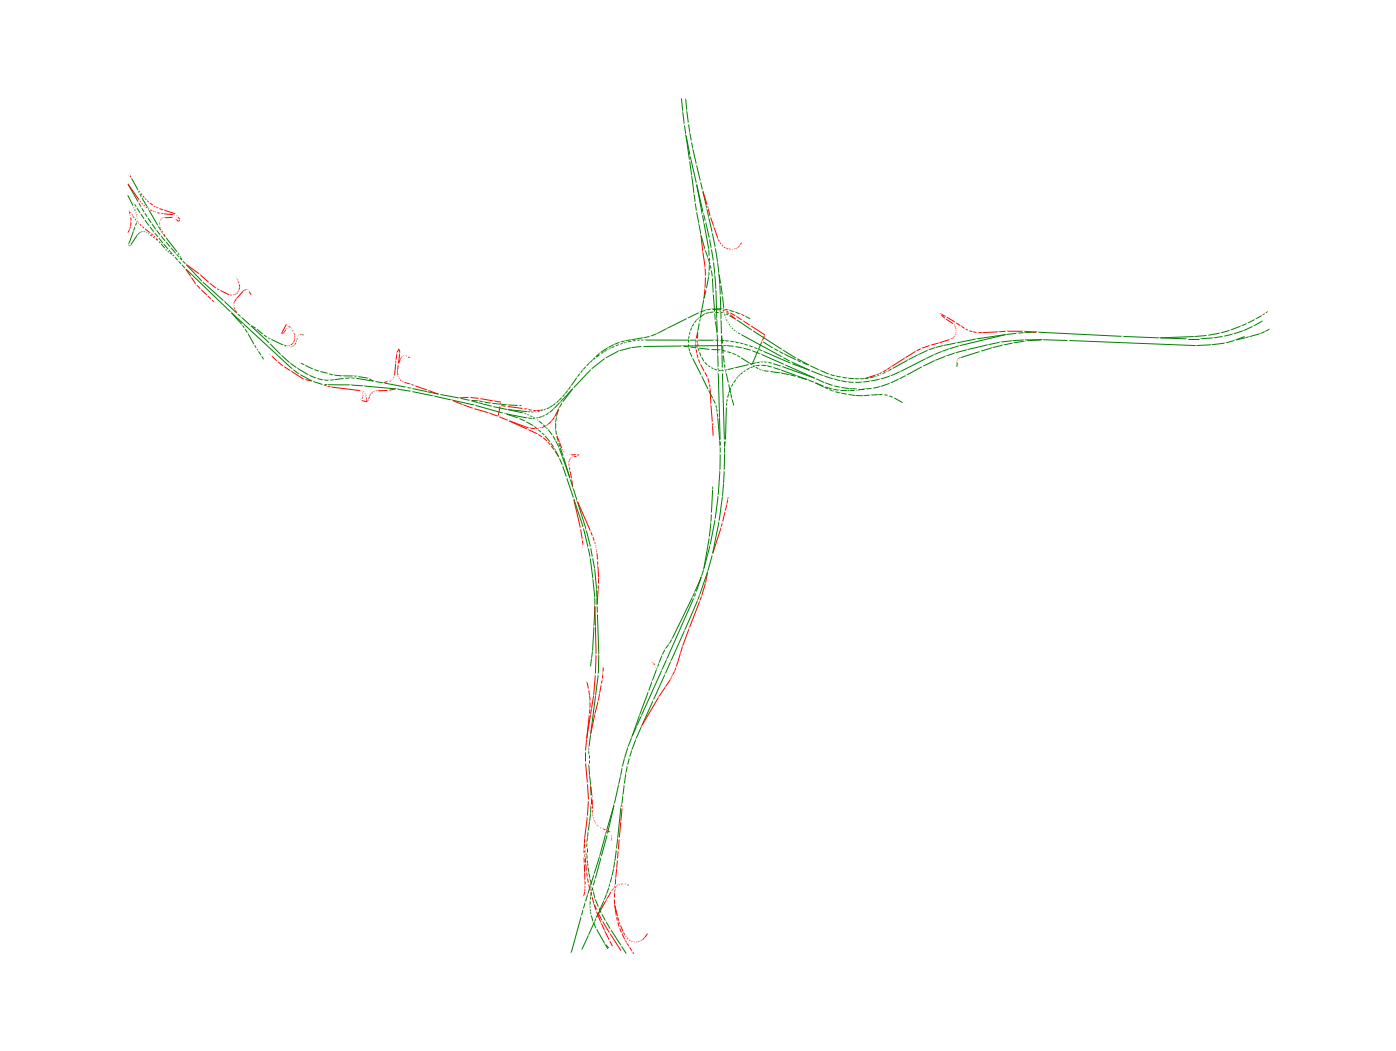

In [44]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}
cmap = mpl.colormaps["viridis"]

G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"])
nx.set_node_attributes(G, nodes.to_dict("index"))

edge_colors = ["red" if G[u][v]["flow"] == 0 else "green" for u,v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

(array([1.111e+03, 5.800e+01, 1.900e+01, 1.500e+01, 2.000e+00, 1.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([     0.,  64140., 128280., 192420., 256560., 320700., 384840.,
        448980., 513120., 577260., 641400.]),
 <BarContainer object of 10 artists>)

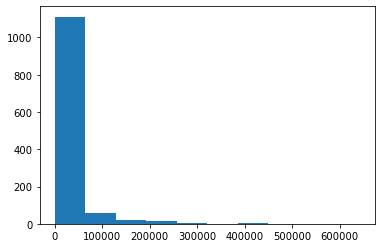

In [45]:
plt.hist([G[u][v]["flow"] for u,v in G.edges])

(array([14269839.,  2608926.,  1326571.,   223273.,   202314.,   204475.,
          202537.,   191109.,   195266.,  1929345.]),
 array([ 0.   ,  2.906,  5.812,  8.718, 11.624, 14.53 , 17.436, 20.342,
        23.248, 26.154, 29.06 ]),
 <BarContainer object of 10 artists>)

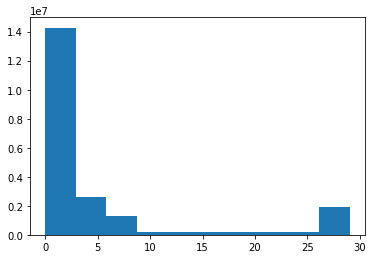

In [47]:
plt.hist(data["vehicle_speed"])

In [60]:
import pandas as pd

data = pd.read_csv("out/test.simulation.csv", sep=";")
data.head()

,timestep_time,edge_id,lane_id,vehicle_id,vehicle_pos,vehicle_speed
0,0.0,:1_0,:1_0_0,NaN,NaN,NaN
1,0.0,:1_2,:1_2_0,NaN,NaN,NaN
2,0.0,:1_1,:1_1_0,NaN,NaN,NaN
3,0.0,:2_0,:2_0_0,NaN,NaN,NaN
4,0.0,:3_0,:3_0_0,NaN,NaN,NaN


In [61]:
data = data.drop(data[data.edge_id.str.startswith(':')].index.values)
data["vehicle_speed"] = data["vehicle_speed"].fillna(0)
data["vehicle_id"] = data["vehicle_id"].fillna(0).apply(lambda x: 1 if x != 0 else 0)
data.head()

,timestep_time,edge_id,lane_id,vehicle_id,vehicle_pos,vehicle_speed
7,0.0,0,0_0,1,0.0,0.1
8,0.0,1,1_0,0,NaN,0.0
9,0.0,2,2_0,0,NaN,0.0
10,0.0,3,3_0,0,NaN,0.0
11,0.0,4,4_0,0,NaN,0.0


In [62]:
data[data["vehicle_id"] == 1]

,timestep_time,edge_id,lane_id,vehicle_id,vehicle_pos,vehicle_speed
7,0.0,0,0_0,1,0.0,0.1


In [63]:
overall = data.groupby(["edge_id"]).agg({'vehicle_id':'sum', 'vehicle_speed':'mean'}).reset_index()
overall = overall.rename(columns={"vehicle_id": "flow"})
overall["edge_id"] = pd.to_numeric(overall["edge_id"])
overall.head()

,edge_id,flow,vehicle_speed
0,0,1,0.016667
1,1,0,0.000000
2,2,0,0.000000
3,3,0,0.000000
4,4,0,0.000000
